In [38]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re

#Loading the dataset and parsing the required information from the dataset. 

In [39]:
# Reading in data
prosodic_file = "data/prosodic_features.csv"
scores_file = "data/scores.csv"
transcript_file = "data/transcripts.csv"

# Read csvs into a file
prosodic_data = pd.read_csv(prosodic_file)
scores_data = pd.read_csv(scores_file)
transcript_data = pd.read_csv(transcript_file)

# Add a column that corresponds to participant for easy splitting for prosodic data
prosodic_data['Participant'] = prosodic_data['participant&question'].str.extract(r'^(PP?\d+)')
prosodic_data['Participant'] = prosodic_data['Participant'].str.lower()
# Make the entire transcript lower case
transcript_data['transcript'] = transcript_data['transcript'].str.lower()

In [40]:
print(prosodic_data.head)

<bound method NDFrame.head of     participant&question    duration    energy  min_pitch   max_pitch  \
0                   P1Q1   51.952125  0.015331  75.232657  396.635613   
1                   P1Q2   38.677312  0.015185  75.165527  397.613041   
2                   P1Q3   43.593896  0.014680  71.034761  395.930688   
3                   P1Q4   23.435813  0.008920  74.938673  248.733738   
4                   P1Q5   13.274833  0.003432  93.949854  263.669188   
..                   ...         ...       ...        ...         ...   
685               PP89Q1   76.333333  0.018540  74.344414  382.978887   
686               PP89Q2   60.628396  0.017723  72.955935  396.654629   
687               PP89Q3  131.118042  0.028155  72.806624  293.105036   
688               PP89Q4   85.464125  0.027269  65.836502  387.213912   
689               PP89Q5   49.306229  0.007684  77.520809  375.522678   

     mean_pitch   pitch_sd   pitch_abs  pitch_quant  pitchUvsVRatio  ...  \
0    127.989222  

In [41]:
# Splitting the participants into 5 folds
num_folds = 5

# Grab participant numbers from the scores csv file
interviews = scores_data['Participant'].unique()
participants = list(set([re.sub(r'^pp?|q\d+', '', item) for item in interviews]))
random.shuffle(participants)
participant_folds = [participants[i::num_folds] for i in range(num_folds)]

for i, fold in enumerate(participant_folds):
  print(f"Fold {i + 1}: {fold}")
  print("\tLength: ", len(fold))

# Grab all the correct interview names associated with each participant
interview_folds = []
for fold in participant_folds:
  interview_folds.append([item for num in fold for item in (f"p{num}", f"pp{num}")])

Fold 1: ['72', '56', '33', '27', '64', '6', '85', '57', '3', '14', '1', '63', '42', '25']
	Length:  14
Fold 2: ['30', '49', '34', '24', '29', '55', '16', '17', '61', '45', '74', '89', '37', '69']
	Length:  14
Fold 3: ['66', '83', '7', '77', '20', '35', '52', '84', '11', '47', '13', '73', '8', '15']
	Length:  14
Fold 4: ['22', '86', '81', '32', '43', '12', '78', '58', '71', '31', '59', '5', '65', '67']
	Length:  14
Fold 5: ['21', '62', '4', '50', '70', '79', '53', '44', '80', '60', '10', '76', '48']
	Length:  13


In [42]:
def get_data_splits(data, fold_number):
    """
    Split data into training, validation, and testing sets based on a specified fold.
    
    Parameters:
        data (DataFrame): The complete dataset.
        fold_number (int): The fold to use for testing (0-based index).
        
    Returns:
        tuple: (training_set, validation_set, testing_set)
    """
    # Quick check on fold number
    assert 0 <= fold_number < len(interview_folds), "Fold_number must be between 0 and len(folds) - 1"

    # Split the data
    test_set = data[data['Participant'].isin( interview_folds[fold_number] )]
    val_set = data[data['Participant'].isin( interview_folds[(fold_number + 1) % len(interview_folds)] )]
    train_set_parts = [item for i, fold in enumerate(interview_folds) if i not in [fold_number, (fold_number + 1) % len(interview_folds)] for item in fold]
    train_set = data[data['Participant'].isin(train_set_parts)]
    return train_set, val_set, test_set

train_set, val_set, test_set = get_data_splits(prosodic_data, 0)
print("Prosodic Data: ")
print(train_set.shape, " ", val_set.shape, " ", test_set.shape)
train_set, val_set, test_set = get_data_splits(scores_data, 0)
print("Scores Data: ")
print(train_set.shape, " ", val_set.shape, " ", test_set.shape)
# print(test_set.head())
train_set, val_set, test_set = get_data_splits(transcript_data, 0)
print("Transcript Data: ")
print(train_set.shape, " ", val_set.shape, " ", test_set.shape)
# print(test_set.head())

Prosodic Data: 
(410, 37)   (140, 37)   (140, 37)
Scores Data: 
(82, 3)   (28, 3)   (28, 3)
Transcript Data: 
(82, 4)   (28, 4)   (28, 4)


Extracting language features

In [ ]:
# !pip install vaderSentiment


In [54]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from transformers import BertTokenizer, BertModel

nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')  # POS Tagger
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon') # Vader

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Syntactic Vectorization with CountVectorizer


In [55]:

# Syntactic vectorizer: CountVectorizer
# Remove common stop words in english and ignore words that appear fewer than 2 times
vectorizer = CountVectorizer(stop_words='english', min_df=2) 
X = vectorizer.fit_transform(transcript_data['transcript'])
# Convert from sparse X matrix to a denser one for easy use
X_dense = X.toarray()
feature_names_count = vectorizer.get_feature_names_out()
word_count = pd.DataFrame(X_dense, columns=feature_names_count)
word_count.head()

,000,10,100,13,14,15,16,18,20,200,...,yep,yes,yo,yoga,york,young,younger,youngest,yup,zone
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Syntactic Vectorization with TFIDF Vectorizer


In [56]:

# Syntactic vectorizer: TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df=2)
tfidf_matrix = tfidf.fit_transform(transcript_data['transcript'])
feature_names_tf = tfidf.get_feature_names_out()
tfidf_count = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names_tf)
tfidf_count.head()

,000,10,100,13,14,15,16,18,20,200,...,yep,yes,yo,yoga,york,young,younger,youngest,yup,zone
0,0.068513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.031465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Statistical Features (word count and average word length)


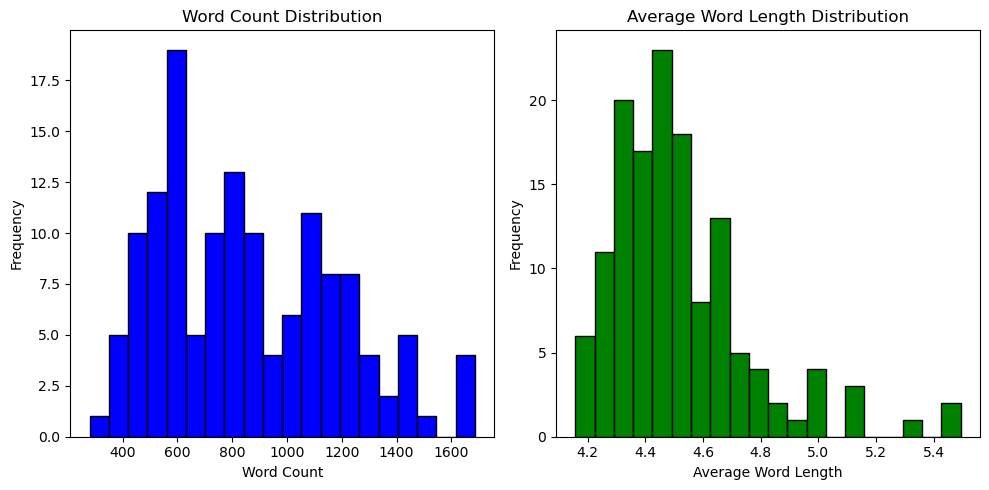

In [86]:
import matplotlib.pyplot as plt

# Statistical Features (word count and average word length)
# Word Count for the entire interview
features = pd.DataFrame()
features['word count'] = transcript_data['transcript'].apply(lambda x: len(x.split()))
# Average word length for the interview
features['avg word length'] = transcript_data['transcript'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
features.head()

# Visualization
plt.figure(figsize=(10, 5))

# Plot word count
plt.subplot(1, 2, 1)
plt.hist(features['word count'], bins=20, color='blue', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot average word length
plt.subplot(1, 2, 2)
plt.hist(features['avg word length'], bins=20, color='green', edgecolor='black')
plt.title('Average Word Length Distribution')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Part of speech tagging 

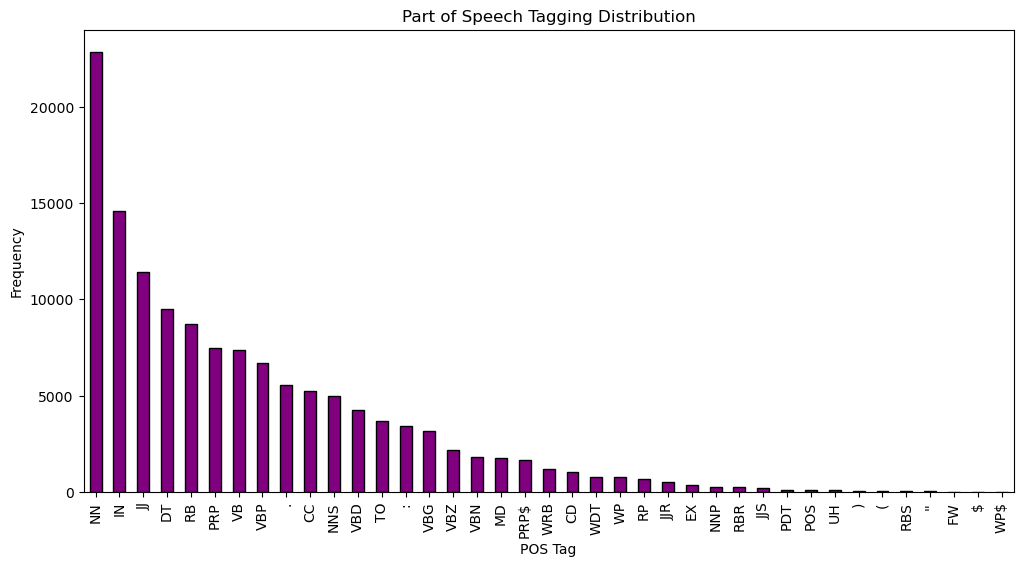

In [87]:
features['pos tagging'] = transcript_data['transcript'].apply(lambda x: pos_tag(word_tokenize(x)))
features['pos tagging'].head()
# NN: Noun singular
# VB: Verb base form
# JJ: Adjective
# RB: Adverb
# DT: Determiner
# IN: Preposition or subordination conjunction

# Visualization of POS tagging
pos_counts = features['pos tagging'].apply(lambda x: [tag for word, tag in x]).explode().value_counts()
plt.figure(figsize=(12, 6))
pos_counts.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Part of Speech Tagging Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.show()

Sentiment Analysis with Vader


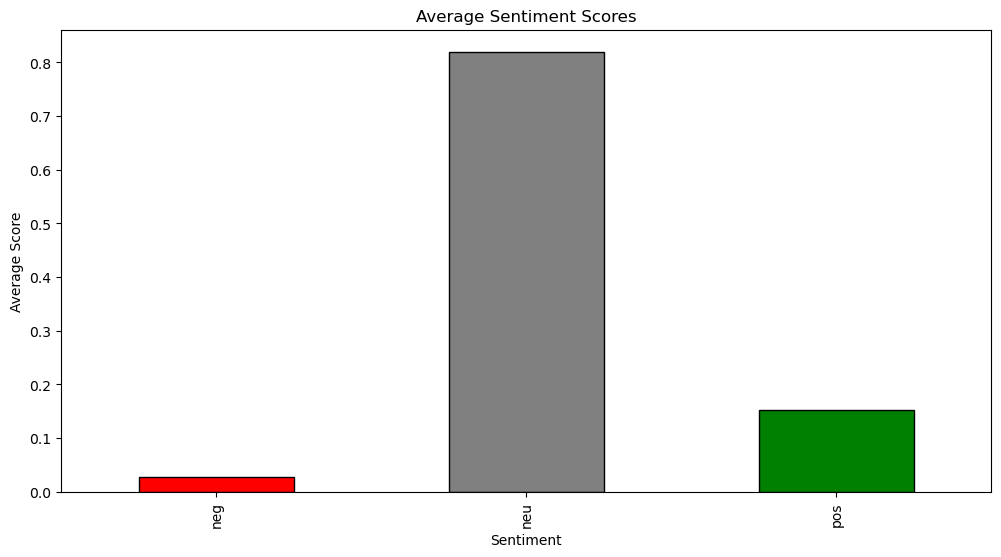

In [88]:
# Sentiment Analysis with Vader
analyzer = SentimentIntensityAnalyzer()
features['sentiment'] = transcript_data['transcript'].apply(lambda x: analyzer.polarity_scores(x))

features['sentiment'].head()

# Visualization of Sentiment Analysis
sentiment_df = pd.DataFrame(features['sentiment'].tolist())
plt.figure(figsize=(12, 6))
sentiment_df[['neg', 'neu', 'pos']].mean().plot(kind='bar', color=['red', 'grey', 'green'], edgecolor='black')
plt.title('Average Sentiment Scores')
plt.xlabel('Sentiment')
plt.ylabel('Average Score')
plt.show()

Word Embeddings with BERT


In [62]:

# Word embeddings with BERT (Hugging Face)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gyani\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

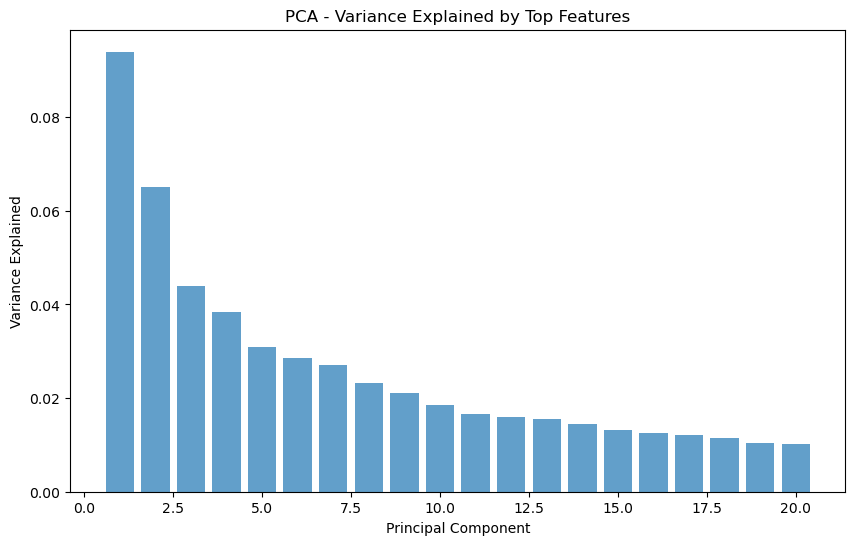

0    [-3.1420894, -1.071909, 0.046536516, 3.4153244...
1    [-4.4565654, 2.7292378, 2.7923934, 2.328033, 1...
2    [6.355875, -2.025031, -1.5772494, 0.6397584, 1...
3    [-4.8692365, -1.6111082, -6.4261017, -2.947821...
4    [-4.671379, -1.636164, -6.3800793, 0.99932396,...
Name: pca word embeddings, dtype: object

In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separate interview into sentences
def process_transcript(text):
    sentences = re.split(r'(?<=\|)', text)
    cleaned_sentences = [
        re.sub(r'^(interviewer:|interviewee:)\s*', '', s.strip().replace('|', '')) for s in sentences if s.strip()
    ]
    return cleaned_sentences

transcript_data['Processed Transcript'] = transcript_data['transcript'].apply(process_transcript)

# Tokenize the text
def get_bert_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        # Tokenize and get input Id and attention mask
        inputs = tokenizer(sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=20)
        # Use BERT
        with torch.no_grad():
            outputs = model(**inputs)
        # Pool output
        cls_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings.append(cls_embedding)
    # Return an array that is the same size
    return np.array(embeddings).flatten()[:6912]

features['word embeddings'] = transcript_data['Processed Transcript'].apply(get_bert_embeddings)

# Perform PCA to find top features
def perform_pca(embeddings, n_components=20):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(embeddings)
    return principal_components, pca.explained_variance_ratio_

# Prepare embeddings for PCA
all_embeddings = np.vstack(features['word embeddings'].values)

# Apply PCA on the word embeddings
pca_components, explained_variance = perform_pca(all_embeddings)

# Visualize the top features
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA - Variance Explained by Top Features')
plt.show()



features['pca word embeddings'] = list(pca_components)
features['pca word embeddings'].head()

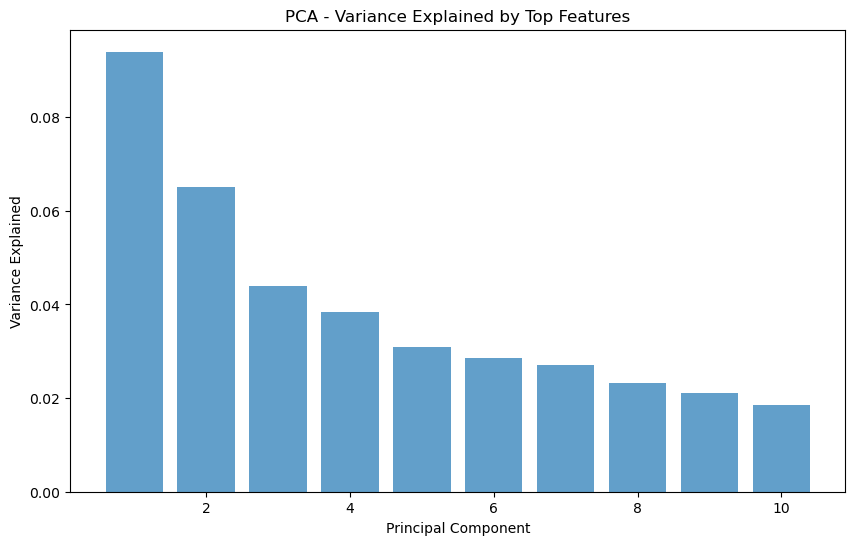

Language Features Extracted:
- Syntactic Vectorization with CountVectorizer
- Syntactic Vectorization with TFIDF Vectorizer
- Word Count
- Average Word Length
- Part of Speech Tagging
- Sentiment Analysis with Vader
- Word Embedding with BERT
  
A total of 7 distinctive features.

The human readable features are: CountVectorizer because it is a count of the words throughout the interview, the Statistical Features, Part of Speech Tagging (with a little extra interpretation), and Sentiment Analysis with Vader.

PCA - to be tried[done above]

Language feature selection part


For this section, we used 2 different filter feature selection methods to try to understand the data better. The first method we use is the pearsonr correlation, which we used to compare word count, average word length, word frequency, and sentiment analysis. Then we used mutual information to compare all of the features we extracted. Mutual information was used because it is good at handling both low-dimensionality (eg Word Count) and high dimensionality (eg BERT embeddings) features and captures non-linear relationships between features and target variables.

Pearson Correlation

In [98]:
import scipy.stats as stats
# Find correlation for the n (number) most impactful words from the word_count CountVectorizer
def find_top_words(number):
  overall_accumulator = []
  excited_accumulator = []
  for word in word_count.columns:
    corr, _ = stats.pearsonr(word_count[word], scores_data["Overall"])
    overall_accumulator.append({"Word": word, "Correlation": corr})
    corr, _ = stats.pearsonr(word_count[word], scores_data["Excited"])
    excited_accumulator.append({"Word": word, "Correlation": corr})

  overall_corr = pd.DataFrame(overall_accumulator)
  excited_corr = pd.DataFrame(excited_accumulator)

  overall_corr["Abs Correlation"] = overall_corr["Correlation"].abs()
  excited_corr["Abs Correlation"] = excited_corr["Correlation"].abs()

  top_10_overall = overall_corr.nlargest(number, 'Abs Correlation')
  top_10_excited = excited_corr.nlargest(number, 'Abs Correlation')

  return [top_10_overall, top_10_excited]


In [99]:
# Using correlation to compare: word count, average word length, word frequency, and sentiment analysis
feature_cols = ["word count", "avg word length"]
outcome_cols = ["Overall", "Excited"]

Overall_correlation = []
Excited_correlation = []

for feature in feature_cols:
  corr, _ = stats.pearsonr(features[feature], scores_data["Overall"])
  Overall_correlation.append({"Feature": feature, "Correlation": corr})
  corr, _ = stats.pearsonr(features[feature], scores_data["Excited"])
  Excited_correlation.append({"Feature": feature, "Correlation": corr})

# Find correlation for the most impactful words from the word_count CountVectorizer
top_overall, top_excited = find_top_words(20)

for _, row in top_overall.iterrows():
  Overall_correlation.append({"Feature": f"word - {row['Word']}", "Correlation": row['Correlation']})

for _, row in top_excited.iterrows():
  Excited_correlation.append({"Feature": f"word - {row['Word']}", "Correlation": row['Correlation']})

# Find correlation for the sentiment analysis
# Expand sentiment column into its own dictionary
sentiment_df = features["sentiment"].apply(pd.Series)
for feature in ['neg', 'neu', 'pos', 'compound']:
  corr, _ = stats.pearsonr(sentiment_df[feature], scores_data["Overall"])
  Overall_correlation.append({"Feature": f"sentiment - {feature}", "Correlation": corr})
  corr, _ = stats.pearsonr(sentiment_df[feature], scores_data["Excited"])
  Excited_correlation.append({"Feature": f"sentiment - {feature}", "Correlation": corr})

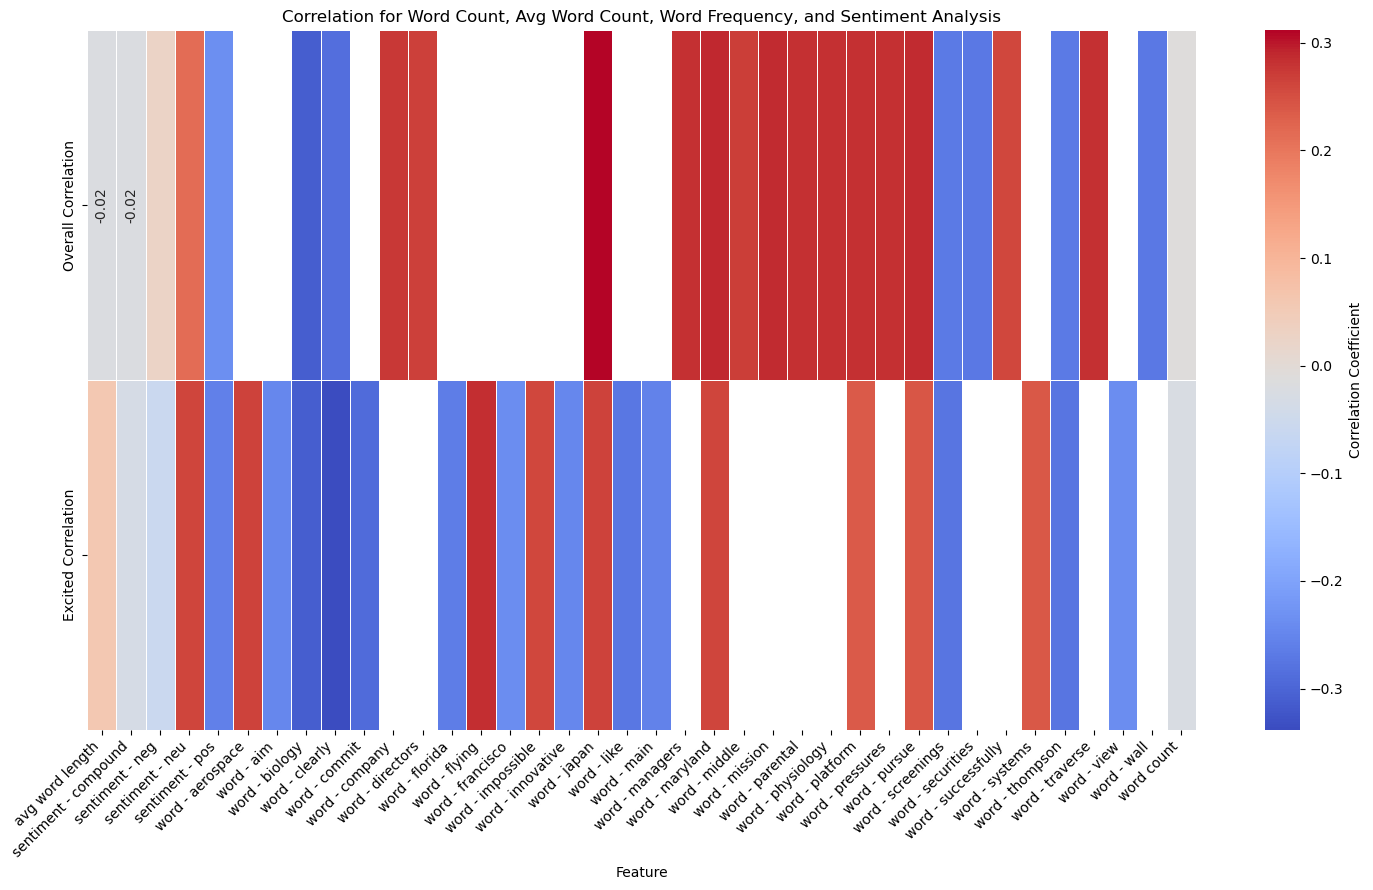

In [101]:
overall_corr_df = pd.DataFrame(Overall_correlation)
overall_corr_df = overall_corr_df.rename(columns={'Correlation': 'Overall Correlation'})
excited_corr_df = pd.DataFrame(Excited_correlation)
excited_corr_df = excited_corr_df.rename(columns={'Correlation': 'Excited Correlation'})
merged_df = pd.merge(overall_corr_df, excited_corr_df, how="outer", on="Feature")
correlation_matrix = merged_df.set_index('Feature').T 

fig, axes = plt.subplots(1, 1, figsize=(15,9))

# Plot overall correlation
ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=.5, 
                 annot_kws={"size": 10}, cbar_kws={"label": "Correlation Coefficient"})
for t in ax.texts: 
    t.set_rotation(90)
    t.set_text(f"{t.get_text()}")  # Ensure the text reflects the color scale

axes.set_title('Correlation for Word Count, Avg Word Count, Word Frequency, and Sentiment Analysis')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

From the correlation, we can see that for the Overall outcome, the strongest positive correlations are: the words japan, maryland, managers, mission, parental, physiology, platform, pressures, and traverse. It is important to note here that the neu sentiment has a 0.21 correlation with the Overall Outcome as well. The strongest negative correlations for the Overall outcome are: pos sentiment (interestingly) and the words biology, clearly, screenings, securities, thompson, and wall. Looking at this, it is pretty clear that although word frequency can be helpful in finding patterns, it is rather random and not the most reliable source of performance on an interview.

For the Excited outcome, the strongest positive correlations are: neu sentiment and the words aerospace, flying, impossible, japan, and maryland. The strongest negative correlations were: pos sentiment (also interesting to note) and the words clearly, biology, screenings, commit, and thompson. These results should again be used with caution as singular words like japan and maryland (probably) don't have anything to do with the performance of the interviewee.

Overall, the statistical (and simple) features of word count and average word length didn't correlate well to either outcome and shouldn't be used. The same could be said about neg sentiment and compuond sentiment. Using neu sentiment and pos sentiment has a decent amount of relevance to the two considered outcomes, and so do a lot of words. The individual words should be used with caution in determining the relevance of those words to the final outcome.

In [68]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder


Top 10 mi features for:  Overall


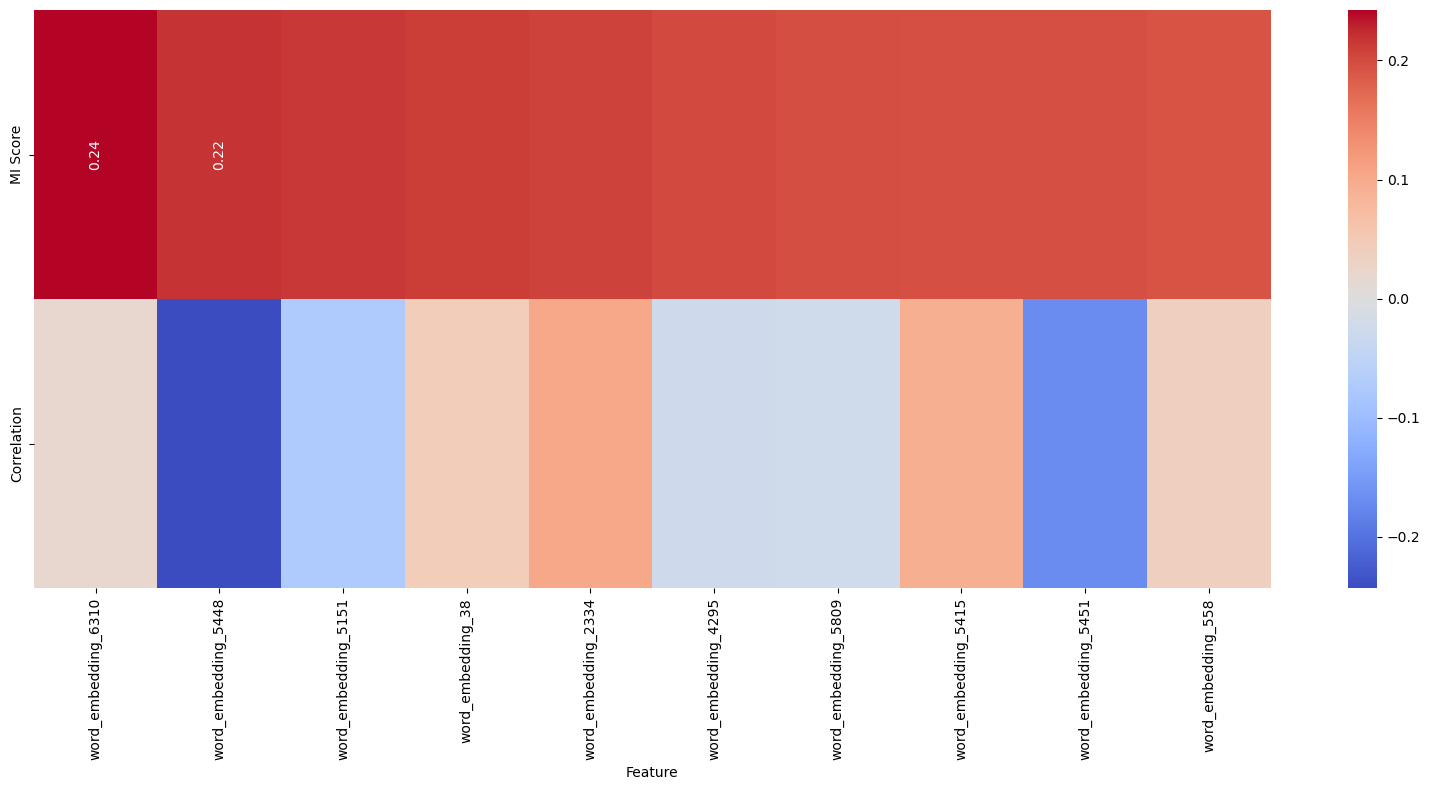


Top 10 correlation features for:  Overall


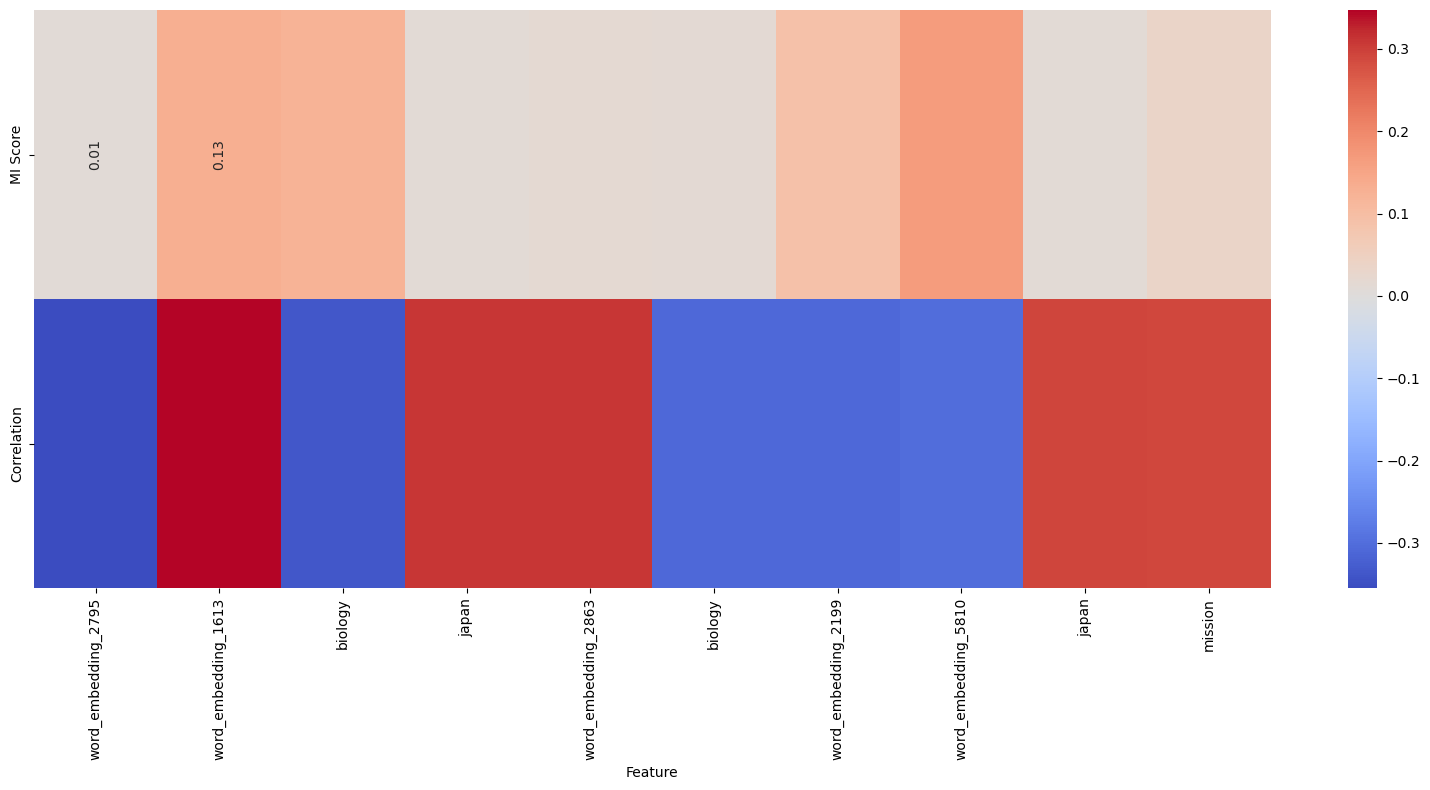


Top 10 mi features for:  Excited


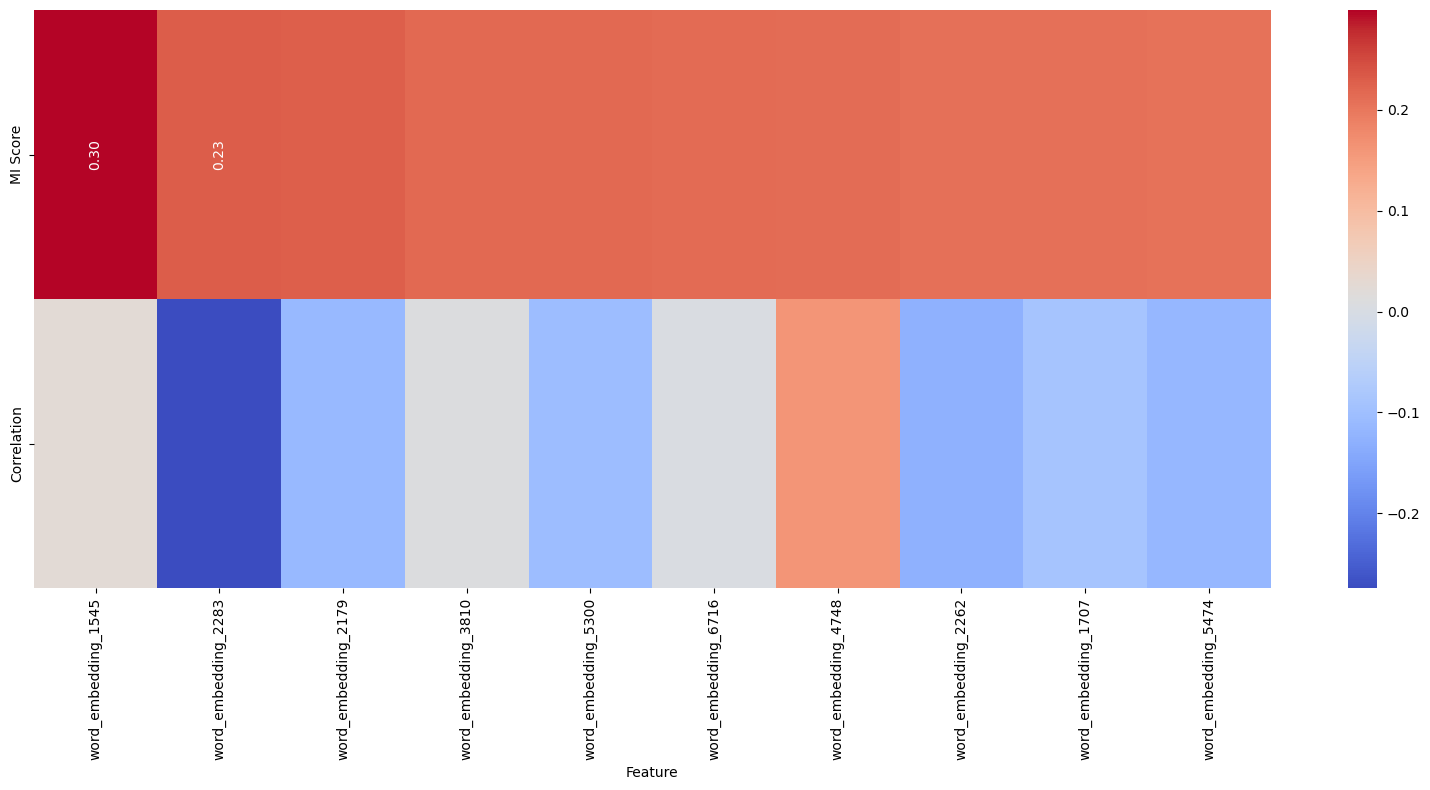


Top 10 correlation features for:  Excited


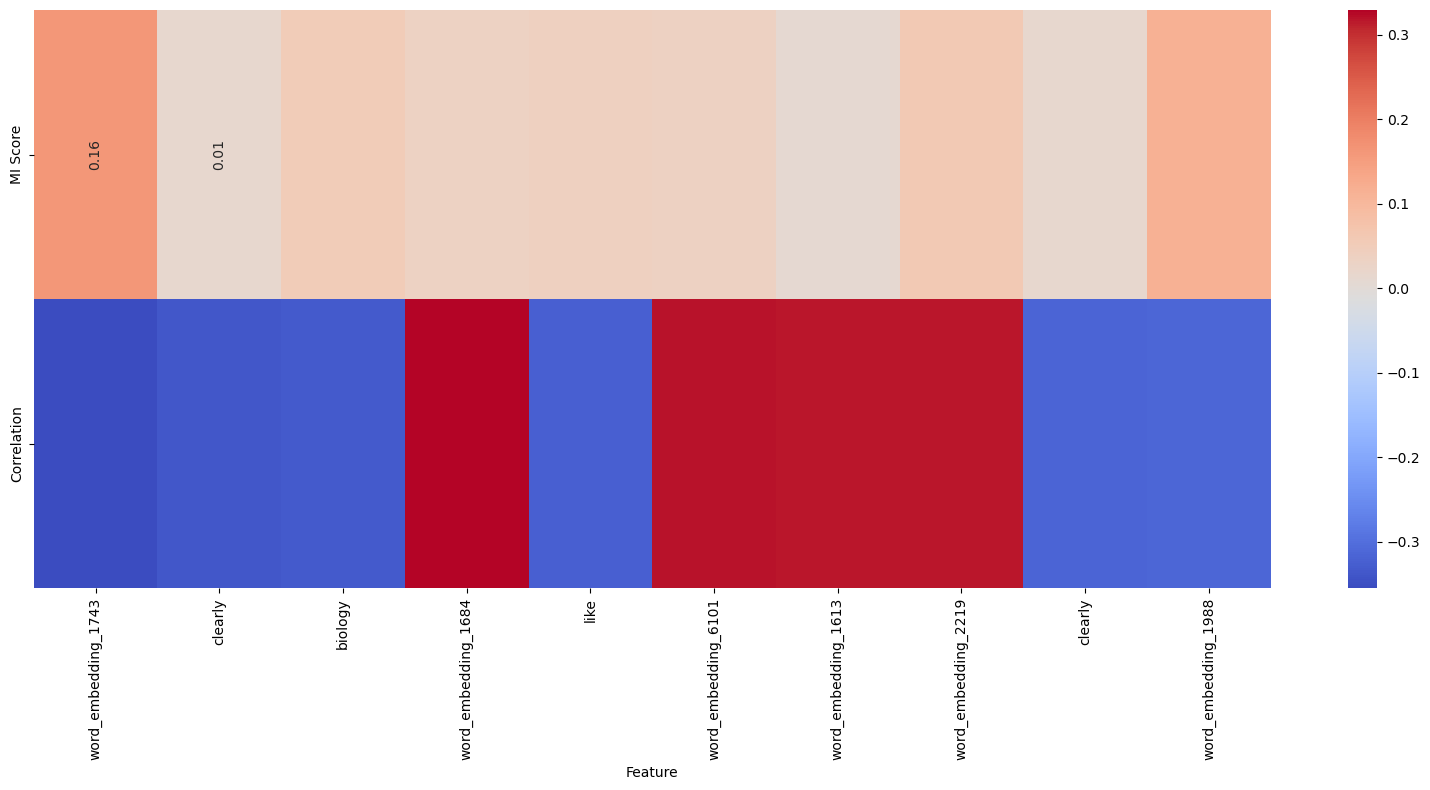

In [72]:
# Use Mutual Information as a filter feature selection method
def get_top_20(X, feature_names):
    for outcome in ["Overall", "Excited"]:
        # Overall target
        y = scores_data[outcome]

        # Use mutual_info_regression for continuous target variable
        mi = mutual_info_regression(X, y)
        correlations = [stats.pearsonr(X[:, i], y)[0] for i in range(X.shape[1])]

        # Convert to a DataFrame to view the features and their MI scores
        mi_df = pd.DataFrame({
            'Feature': feature_names,
            'MI Score': mi,
            'Correlation': correlations
        })

        # Sort by MI score to find the most relevant features
        top_mi_df = mi_df.sort_values(by='MI Score', ascending=False).head(20)

        mi_df['Abs Correlation'] = mi_df['Correlation'].abs()
        top_corr_df = mi_df.sort_values(by='Abs Correlation', ascending=False).head(20)
        top_corr_df = top_corr_df.drop(columns=['Abs Correlation'])
        # Display the top features with high MI score
        print("\nTop 20 mi features for: ", outcome)
        display_corr_graphs(top_mi_df)
        # print(mi_df.head(10))
        print("\nTop 20 correlation features for: ", outcome)
        display_corr_graphs(top_corr_df)
        # print(corr_df.head(10))

def display_corr_graphs(data):
    # This function is for plotting the correlation graphs easily
    # Preprocess the data
    correlations = data.set_index('Feature').T
    # Make the figure
    plt.figure(figsize=(16,8))
    ax = sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    for t in ax.texts: t.set_rotation(90)
    plt.tight_layout()
    plt.show()
# Find the top 10 contributing features to the results for both Overall and Excited

word_emb_features = np.vstack(features['word embeddings'].values)
# Combine all features in to a single matrix X
X = np.hstack([X_dense, tfidf_matrix.toarray(), 
    features['word count'].values.reshape(-1, 1),
    features['avg word length'].values.reshape(-1, 1),
    features['pos tagging'].apply(len).values.reshape(-1, 1),
    sentiment_df['neg'].values.reshape(-1, 1),
    sentiment_df['neu'].values.reshape(-1, 1),
    sentiment_df['pos'].values.reshape(-1, 1),
    sentiment_df['compound'].values.reshape(-1, 1),
    word_emb_features
])

feature_names = (
    feature_names_count.tolist() + 
    feature_names_tf.tolist() + 
    ["word_count"] + 
    ["avg_word_length"] +
    ['POS_tagging_length'] +
    ["neg"] + ["neu"] + ['pos'] + ['compound'] +
    ['word_embedding_' + str(i) for i in range(word_emb_features.shape[1])]
)

get_top_20(X, feature_names)

Discussion - Overall outcome
Using mutual information and pearson correlation show 2 different results for the most relevant features. This is because they are using different criteria to evaluate on, and can give us some interesting information. For example, word_embedding_5448 has a high relevancy with both correlation (negative) and mi score and could be a very good indicator of success for overall performance. The same could be said of word embeddings 108 and 5451 (also negative). However, the correlation for some of these features are a lot lower and less strong (such as word embedding 4295). The top 10 correlations show that word embeddings and words (like japan (positive) and biology (negative)) are strong. These words are rather random though, and using them within the data selection should be done with caution.

Discussion - Excited outcome
Very similar paterns from the Overall outcome can be seen in the Excited outcome. For the mutual information, word embeddings had the highest value all across the board with questionable correlation values just like the overall outcome. Additionally, the correlation feature highlights the negative correlation between clearly, biology, like, and a few word embeddings while also showing the positive correlation between certain word embeddings and the excited outcome.

Continuing
These results are not incredibly human readable, so we took out the embeddings part to see what other features play a big role in the outputs.


Top 10 mi features for:  Overall


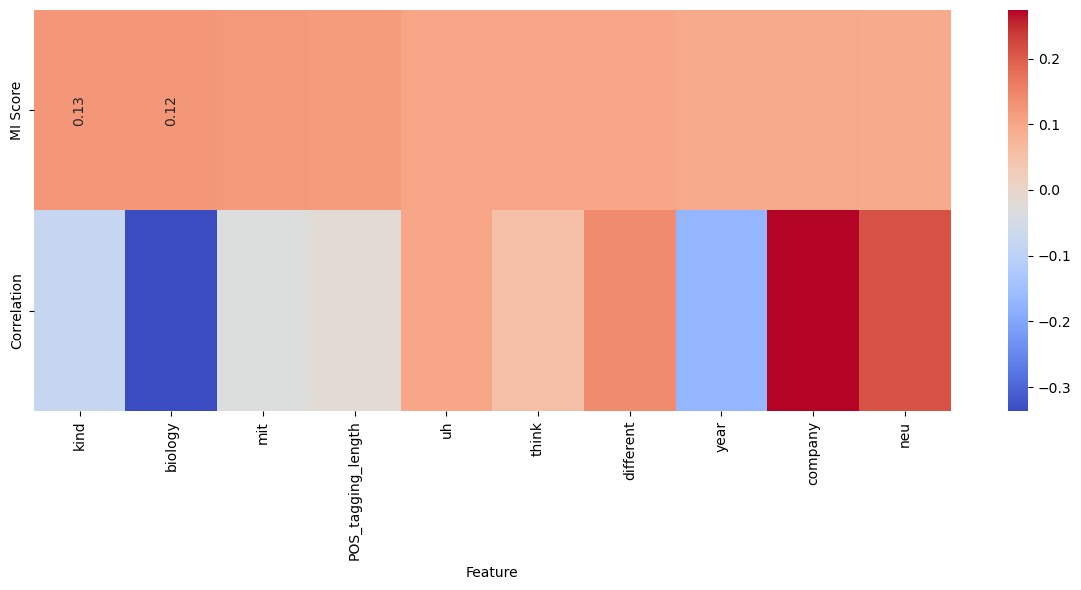


Top 10 correlation features for:  Overall


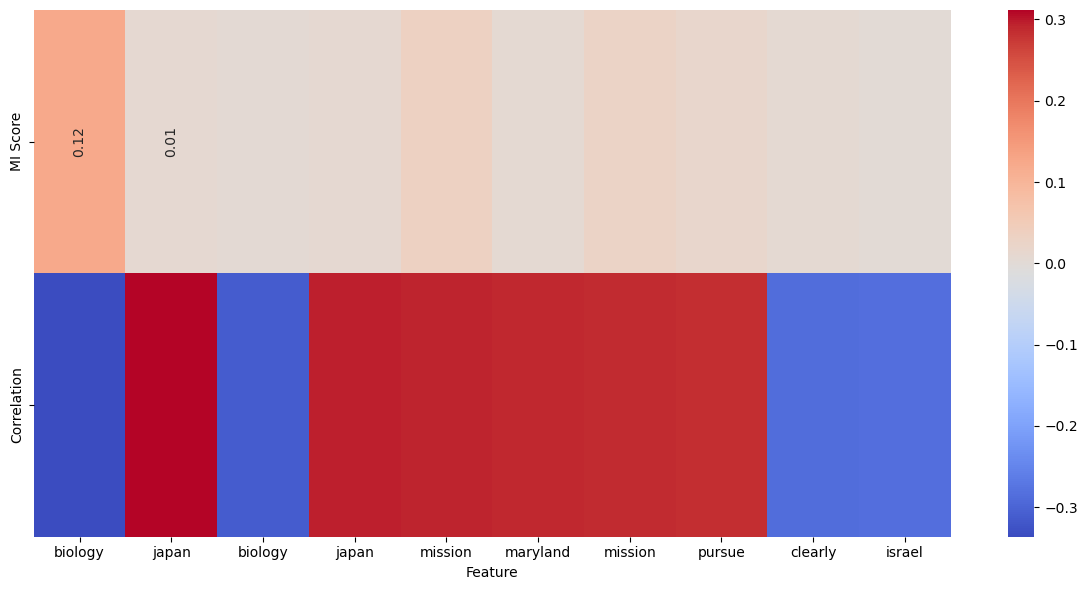


Top 10 mi features for:  Excited


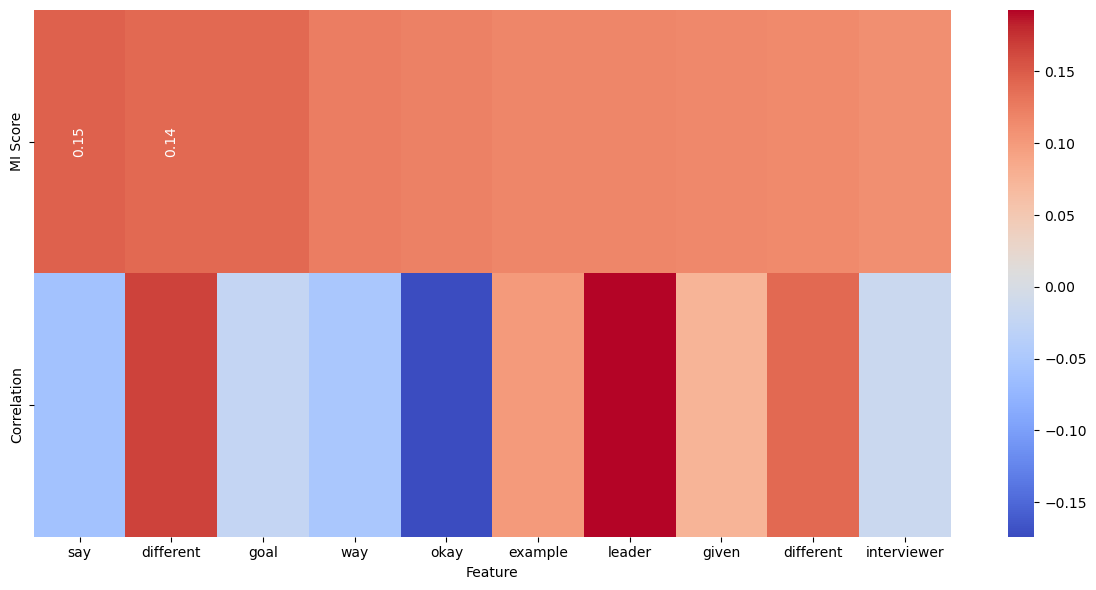


Top 10 correlation features for:  Excited


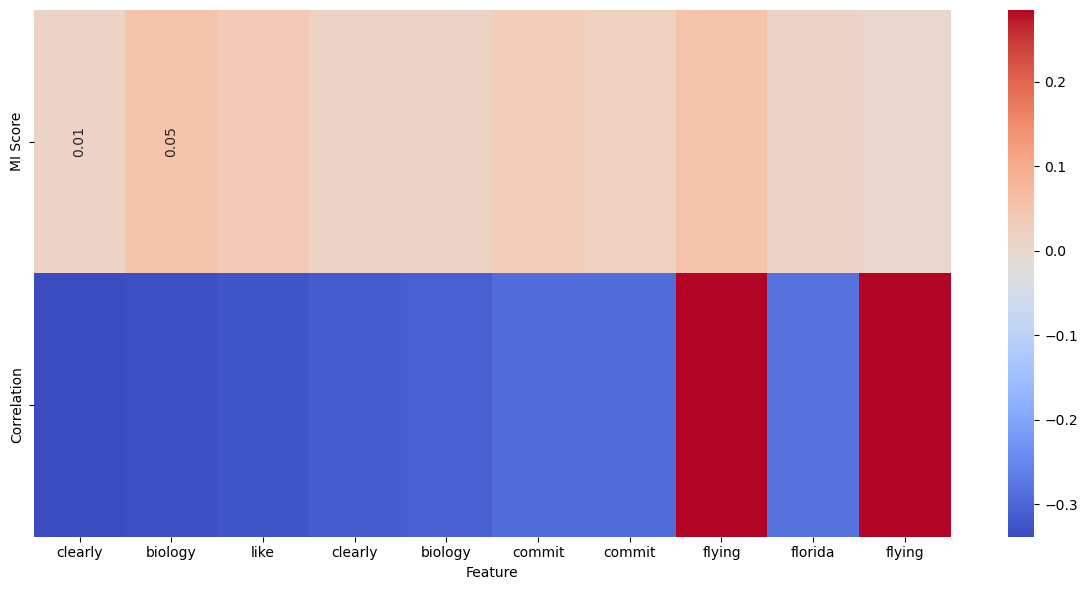

In [71]:
# Lets do a more human readable version of this (since word embedding isn't very human readable)

# Combine all features in to a single matrix X
X = np.hstack([X_dense, tfidf_matrix.toarray(), 
    features['word count'].values.reshape(-1, 1),
    features['avg word length'].values.reshape(-1, 1),
    features['pos tagging'].apply(len).values.reshape(-1, 1),
    sentiment_df['neg'].values.reshape(-1, 1),
    sentiment_df['neu'].values.reshape(-1, 1),
    sentiment_df['pos'].values.reshape(-1, 1),
    sentiment_df['compound'].values.reshape(-1, 1)
])

feature_names = (
    feature_names_count.tolist() + 
    feature_names_tf.tolist() + 
    ["word_count"] + 
    ["avg_word_length"] +
    ['POS_tagging_length'] +
    ["neg"] + ["neu"] + ['pos'] + ['compound']
)

get_top_10(X, feature_names)

Discussion - Overall outcome
Without the word embeddings, it becomes easier to see what human readable features are important. For example, Parts of Speech tagging becomes important (slight negative correlation) in mutual information. We also continue to see this pattern of certain words being helpful (such as biology being negatively correlated and company being positively correlated). For the best correlation values, these numbers are not a surprise because they show up on many of the other splitting mechanisms.

Discussion - Excited outcome
Without the word embeddings for the excited outcome, almost all of the highest outcomes are associated with singular words. These have also been the same words that we have been seeing through the various other methods of filtering features.

Actionable insight to the user
Looking at these outcomes, a user could take action on some of the insights by using more of the language that is positively associated with the 2 outcomes (overall and excited). A great example of this would be to look at the words that have the most negative correlation to performance and to try to avoid these words in an interview. Additionally, from the study paper, they extracted interesting features that had high correlation with positive outcomes such as using words like 'we' more than 'I', and using less filler words throughout the interview.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define the features and the target outcomes
X = features[['word count', 'avg word length', 'pos tagging', 'sentiment', 'word embeddings']]
y = outcomes  # Assuming 'outcomes' is a predefined variable containing the target outcomes

# Apply SelectKBest to extract the top k features
k = 5  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support(indices=True)]

# Display the selected features and their scores
feature_scores = selector.scores_[selector.get_support()]
for feature, score in zip(selected_features, feature_scores):
    print(f"Feature: {feature}, Score: {score}")

# Discuss findings
# The selected features are the most relevant to the considered outcomes based on the ANOVA F-value.
# These features can provide actionable insights to the user by highlighting the most important aspects
# of the language used in the interviews. For example, if 'word count' is positively associated with
# successful outcomes, users can focus on increasing the length of their responses. Similarly, if
# 'sentiment' is negatively associated with successful outcomes, users can work on improving the
# positivity of their language.
